<a href="https://colab.research.google.com/github/pranavsuriya-sr/EVPredCoolant/blob/main/motorspeed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_csv('PADERBON_new.csv')

In [3]:
avg_coolant = df['coolant'].mean()
print(f"Average coolant: {avg_coolant}")

Average coolant: 18.75226135372281


In [4]:
features = ['timestamp','u_q', 'motor_speed', 'stator_winding', 'u_d', 'i_d', 'i_q', 'pm', 'torque']
target = 'coolant'

In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [6]:
X = scaled_data[:, :-1]
y = scaled_data[:, -1]

In [7]:
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [9]:
model = Sequential()

# Add 4 LSTM layers with dropout
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))

# Add Dense layer for prediction
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 0.0171 - val_loss: nan
Epoch 2/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 76s 9ms/step - loss: 0.0044 - val_loss: nan
Epoch 3/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0040 - val_loss: nan
Epoch 4/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.0037 - val_loss: nan
Epoch 5/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0037 - val_loss: nan
Epoch 6/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.0036 - val_loss: nan
Epoch 7/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 0.0035 - val_loss: nan
Epoch 8/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0035 - val_loss: nan
Epoch 9/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0033 - val_loss: nan
Epoch 10/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0033 - val_loss: nan
Epoch 11/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0033 - val_loss: nan
Epoch 12/50
3956/3956 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms

In [12]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

989/989 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: nan
Test Loss: nan


In [13]:
model.save('motor_coolant.h5')
model.save_weights('motor_coolant_custom_weights.weights.h5')

In [14]:
y_pred = model.predict(X_test)

989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [15]:
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, 0], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, 0], y_pred.reshape(-1, 1)), axis=1))[:, -1]

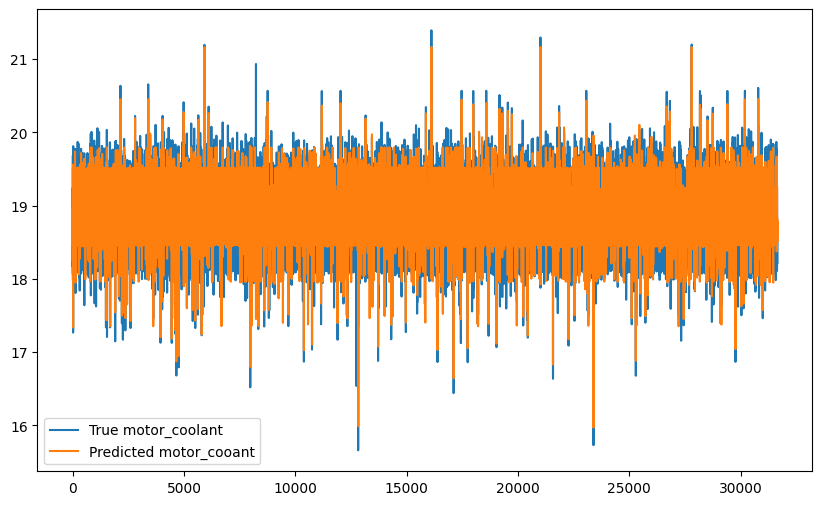

In [17]:
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='True motor_coolant')
plt.plot(y_pred_rescaled, label='Predicted motor_cooant')
plt.legend()
plt.show()

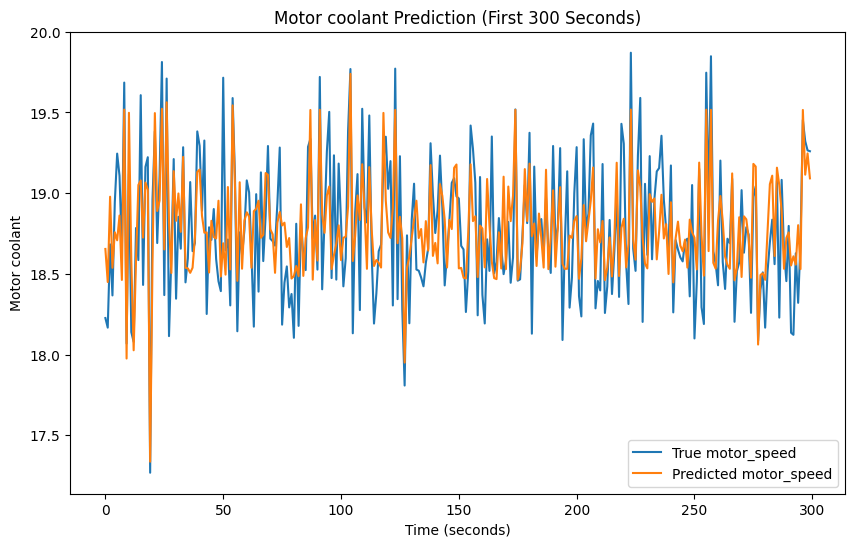

In [19]:
import matplotlib.pyplot as plt

# Assuming y_test_rescaled and y_pred_rescaled are arrays of motor speed values

# Plot for the first 300 seconds
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[:300], label='True motor_speed')
plt.plot(y_pred_rescaled[:300], label='Predicted motor_speed')
plt.legend()
plt.title("Motor coolant Prediction (First 300 Seconds)")
plt.xlabel("Time (seconds)")
plt.ylabel("Motor coolant")
plt.show()


In [20]:
def predict_custom_input(custom_input):
    custom_input_scaled = scaler.transform([custom_input])
    custom_input_reshaped = custom_input_scaled[:, :-1].reshape(1, 1, len(features))
    prediction = model.predict(custom_input_reshaped)
    prediction_rescaled = scaler.inverse_transform(np.concatenate((custom_input_reshaped[:, 0], prediction), axis=1))[:, -1]
    return prediction_rescaled

# Example custom input
custom_input = [0.5,-0.4, 18.08, 19.08, -0.35, 0, 0.0044, 0.0003, 24.554, 0.187]  # Modify as per your need
output = predict_custom_input(custom_input)
print(f"Predicted motor speed for custom input: {output}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted motor speed for custom input: [19.59356827]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
